<a href="https://colab.research.google.com/github/n0vay/EDFAR/blob/master/baseline_cutout_pcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----
# Objective

Data augmentation refers to synthetically increasing the amount of training data by transforming the existing training examples. Data augmentation has been shown to be a very useful technique, especially in computer vision applications. However, there are multiple ways of performing data augmentation and it is yet to be understood which transformations are more effective and why, and how data augmentation interacts with other techniques. In fact, it is common to see different augmentation schemes and setups in different papers. For example, there are perceptually possible image transformations (related to human visual perception), simple synthetic transformations such as cutout, more artificial transformations such as mixup that even transform the class labels, among many others.  

In this notebook, we will show how to train deep neural networks for image classification with data augmentation and analyse the results.

---
# Setup


In [1]:
# @title Install dependencies
!pip install pandas --quiet

In [2]:
# imports
import os
import csv
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
set_seed(seed=2021)
set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


'cuda'

### Training hyperparameters

**Note:** We have reduced the number of epochs, `end_epochs`. The value was set to 200. Please, change it back and run the code.

In [6]:
# hyper-parameters
use_cuda = torch.cuda.is_available()
alpha = 1  # alpha for mixup augmentation
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 128
end_apochs = 25  # Please change this to 200
base_learning_rate = 0.1
cutout = False  # True/False if you want to use cutout augmentation
#mixup = False  # True/False if you want to use mixup augmentation
n_holes = 1  # number of holes to cut out from image for cutout
length = 16  # length of the holes for cutout augmentation
#torchvision_transforms = False  # True/False if you want use torchvision augmentations

---
# Data

## Datasets

We will start using CIFAR-10 data set from PyTorch, but with small tweaks we can get any other data we are interested in. 

In [7]:
# @markdown Download and prepare Data
print('==> Preparing data...')
def percentageSplit(full_dataset, percent=0.0):
  set1_size = int(percent * len(full_dataset))
  set2_size = len(full_dataset) - set1_size
  final_dataset, _ = torch.utils.data.random_split(full_dataset,
                                                   [set1_size, set2_size])
  return final_dataset


# CIFAR10 normalizing
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# torchvision transforms
transform_train = transforms.Compose([])
transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
transform_train.transforms.append(transforms.RandomHorizontalFlip())

transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))
#if cutout:
#transform_train.transforms.append(Cutout(n_holes=n_holes, length=length))

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True,
    transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True,
    transform=transform_test)

==> Preparing data...


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


#### CIFAR-10

CIFAR-10 is a data set of 50,000 colour (RGB) training images and 10,000 test images, of size 32 x 32 pixels. Each image is labelled as 1 of 10 possible classes: 
```
'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
```
The data set is stored as a custom `torchvision.datasets.cifar.CIFAR` object. You can check some of its properties with the following code:

In [8]:
print(f"Object type: {type(trainset)}")
print(f"Training data shape: {trainset.data.shape}")
print(f"Test data shape: {testset.data.shape}")
print(f"Number of classes: {np.unique(trainset.targets).shape[0]}")

Object type: <class 'torchvision.datasets.cifar.CIFAR10'>
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Number of classes: 10


In [9]:
# choose percentage from the trainset. set percent = 1.0 to use the whole train data
percent = 1.0
trainset = percentageSplit(trainset, percent = percent)
print(f"size of the new trainset: {len(trainset)}")

size of the new trainset: 50000


## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

In [10]:
# Dataloader
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


## Visualization

To visualize some of the augmentations, make sure you set to ```True``` their corresponding flags in the hyperparameters section

In [11]:
# get batch of data
batch_X, batch_Y =  next(iter(trainloader))

In [12]:
def plot_mixed_images(images):
  inv_normalize = transforms.Normalize(
                      mean= [-m/s for m, s in zip(mean, std)],
                      std= [1/s for s in std]
                      )
  inv_PIL = transforms.ToPILImage()
  fig = plt.figure(figsize=(10, 8))
  for i in range(1, len(images) + 1):
    image = images[i-1]
    ax = fig.add_subplot(1, 4, i)
    inv_tensor = inv_normalize(image).cpu()
    ax.imshow(inv_PIL(inv_tensor))
  plt.show()

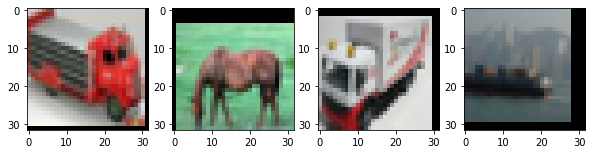

In [13]:
plot_mixed_images(batch_X[:4])

---
# Model

## Architecture: ResNet

ResNet is a family of network architectures whose main property is that the network is organised as a stack of _residual blocks_. Residual blocks consist of a stack of layers whose output is added the input, making a _shortcut connection_.

See the [original paper](https://arxiv.org/abs/1512.03385) for more details.

ResNet is just a popular choice out of many others, but data augmentation works well in general. We just picked ResNet for illustration purposes.

In [14]:
# @markdown ResNet model in PyTorch

class BasicBlock(nn.Module):
  """ResNet in PyTorch.
        Reference:
        [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
        Deep Residual Learning for Image Recognition.
        arXiv:1512.03385
  """
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])


## Model setup and test

In [15]:
# load the Model
net = ResNet18()
print('-----> verify if model is run on random data')
y = net(Variable(torch.randn(1,3,32,32)))
print('model loaded')

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + net.__class__.__name__ + '_' + '.csv'

if use_cuda:
  net.cuda()
  net = torch.nn.DataParallel(net)
  print('Using', torch.cuda.device_count(), 'GPUs.')
  cudnn.benchmark = True
  print('Using CUDA..')

-----> verify if model is run on random data
model loaded
Using 1 GPUs.
Using CUDA..


---
# Training

## Loss function and Optimizer

We use the cross entropy loss, commonly used for classification, and stochastic gradient descent (SGD) as optimizer, with momentum and weight decay.

In [16]:
# optimizer and criterion

criterion = nn.CrossEntropyLoss()  # only for test data
optimizer = optim.SGD(net.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

## Train and test loops

In [17]:
# Training & Test functions
def train(epoch, alpha, use_cuda=False):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
      optimizer.zero_grad()
      inputs, targets = Variable(inputs), Variable(targets)
      outputs = net(inputs)
      loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(epoch, use_cuda=False):
  global best_acc
  net.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
      # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(acc, epoch)
  return (test_loss/batch_idx, 100.*correct/total)

### Auxiliary functions

* `checkpoint()`: Store checkpoints of the model
* `adjust_learning_rate()`: Decreases the learning rate (learning rate decay) at certain epochs of training.

In [18]:
# @markdown `checkpoint` and `adjust_learning_rate` functions
def checkpoint(acc, epoch):
  # Save checkpoint.
  print('Saving..')
  state = {
      'net': net.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
      }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
  torch.save(state, './checkpoint/ckpt.t7')


def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [19]:
# start training
if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['epoch', 'train loss', 'train acc',
                        'test loss', 'test acc'])

for epoch in range(start_epoch, end_apochs):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(epoch, alpha, use_cuda=use_cuda)
  test_loss, test_acc = test(epoch, use_cuda=use_cuda)
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(),
                        test_loss, test_acc.item()])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
0 391 Loss: 2.425 | Acc: 10.938% (14/128)
0 79 Loss: 1.544 | Acc: 44.531% (57/128)
Saving..
Epoch: 0 | train acc: 33.25600051879883 | test acc: 44.959999084472656

Epoch: 1
0 391 Loss: 1.596 | Acc: 46.094% (59/128)
0 79 Loss: 1.170 | Acc: 55.469% (71/128)
Saving..
Epoch: 1 | train acc: 50.20399856567383 | test acc: 55.86000061035156

Epoch: 2
0 391 Loss: 1.180 | Acc: 56.250% (72/128)
0 79 Loss: 1.132 | Acc: 57.031% (73/128)
Saving..
Epoch: 2 | train acc: 61.650001525878906 | test acc: 59.970001220703125

Epoch: 3
0 391 Loss: 1.032 | Acc: 61.719% (79/128)
0 79 Loss: 0.736 | Acc: 69.531% (89/128)
Saving..
Epoch: 3 | train acc: 68.02799987792969 | test acc: 71.27999877929688

Epoch: 4
0 391 Loss: 0.791 | Acc: 69.531% (89/128)
0 79 Loss: 0.692 | Acc: 73.438% (94/128)
Saving..
Epoch: 4 | train acc: 72.53800201416016 | test acc: 72.69000244140625

Epoch: 5
0 391 Loss: 0.670 | Acc: 77.344% (99/128)
0 79 Loss: 0.550 | Acc: 78.125% (100/128)
Saving..
Epoch: 5 | train acc: 75.961997985

In [20]:
# plot results
results = pd.read_csv('/content/results/ResNet_.csv', sep=',')
results.head()

,epoch,train loss,train acc,test loss,test acc
0,0,1.855285,33.256001,1.534558,44.959999
1,1,1.367617,50.203999,1.231491,55.860001
2,2,1.076230,61.650002,1.185992,59.970001
3,3,0.903846,68.028000,0.836400,71.279999
4,4,0.776712,72.538002,0.782205,72.690002


In [21]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f"Average test Accuracy over {end_apochs} epochs: {sum(test_accuracy)//len(test_accuracy)}")
print(f"best test accuraccy over {end_apochs} epochs: {max(test_accuracy)}")

Average test Accuracy over 25 epochs: 79.0
best test accuraccy over 25 epochs: 89.02999877929688


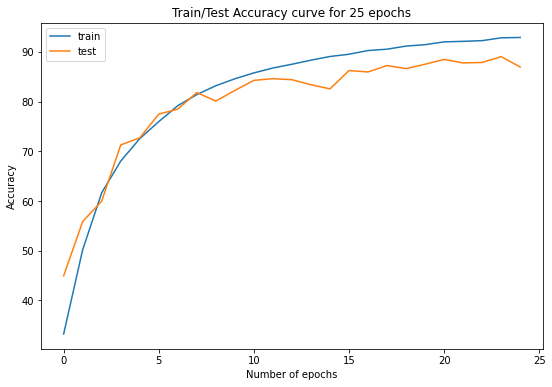

In [22]:
figureName = 'WithMixUp' # change figure name

plt.figure(figsize=(9, 6))
plt.plot(results['epoch'].values, train_accuracy, label='train')
plt.plot(results['epoch'].values, test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {end_apochs} epochs')
plt.savefig(f'/content/results/{figureName}.png')
plt.legend()
plt.show()

#Training with Augmented Data

In [23]:
class Cutout(object):
  """
  code from: https://github.com/uoguelph-mlrg/Cutout

  Randomly mask out one or more patches from an image.
  Args:
      n_holes (int): Number of patches to cut out of each image.
      length (int): The length (in pixels) of each square patch.
  """
  def __init__(self, n_holes, length):
    self.n_holes = n_holes
    self.length = length

  def __call__(self, img):
    """
    Args:
        img (Tensor): Tensor image of size (C, H, W).
    Returns:
        Tensor: Image with n_holes of dimension length x length cut out of it.
    """
    h = img.size(1)
    w = img.size(2)

    mask = np.ones((h, w), np.float32)

    for n in range(self.n_holes):
      y = np.random.randint(h)
      x = np.random.randint(w)

      y1 = np.clip(y - self.length // 2, 0, h)
      y2 = np.clip(y + self.length // 2, 0, h)
      x1 = np.clip(x - self.length // 2, 0, w)
      x2 = np.clip(x + self.length // 2, 0, w)

      mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img = img * mask

    return img

In [24]:
# @markdown Download and prepare Data
print('==> Preparing data...')
def percentageSplit(full_dataset, percent=0.0):
  set1_size = int(percent * len(full_dataset))
  set2_size = len(full_dataset) - set1_size
  final_dataset, _ = torch.utils.data.random_split(full_dataset,
                                                   [set1_size, set2_size])
  return final_dataset


# CIFAR10 normalizing
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# torchvision transforms
transform_train = transforms.Compose([])

transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
transform_train.transforms.append(transforms.RandomHorizontalFlip())
transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))
transform_train.transforms.append(Cutout(n_holes=n_holes, length=length))

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True,
    transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True,
    transform=transform_test)

==> Preparing data...
Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Dataloader
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


In [26]:
batch_X, batch_Y =  next(iter(trainloader))

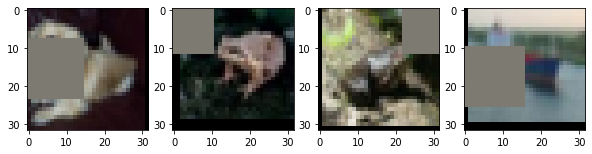

In [27]:
plot_mixed_images(batch_X[:4])

In [28]:
# Training & Test functions
def train(epoch, alpha, use_cuda=False):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
    optimizer.zero_grad()
    
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)

    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(epoch, use_cuda=False):
  global best_acc
  net.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
      # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(acc, epoch)
  return (test_loss/batch_idx, 100.*correct/total)

In [29]:
# start training
if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['epoch', 'train loss', 'train acc',
                        'test loss', 'test acc'])

for epoch in range(start_epoch, end_apochs):
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(epoch, alpha, use_cuda=use_cuda)
  test_loss, test_acc = test(epoch, use_cuda=use_cuda)
  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([epoch, train_loss, train_acc.item(),
                        test_loss, test_acc.item()])
  print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
0 391 Loss: 0.793 | Acc: 75.781% (97/128)
0 79 Loss: 0.303 | Acc: 88.281% (113/128)
Epoch: 0 | train acc: 83.77799987792969 | test acc: 87.55999755859375

Epoch: 1
0 391 Loss: 0.300 | Acc: 89.844% (115/128)
0 79 Loss: 0.304 | Acc: 89.062% (114/128)
Epoch: 1 | train acc: 85.62799835205078 | test acc: 87.04000091552734

Epoch: 2
0 391 Loss: 0.413 | Acc: 85.938% (110/128)
0 79 Loss: 0.390 | Acc: 86.719% (111/128)
Epoch: 2 | train acc: 86.49199676513672 | test acc: 86.87000274658203

Epoch: 3
0 391 Loss: 0.309 | Acc: 89.062% (114/128)
0 79 Loss: 0.335 | Acc: 88.281% (113/128)
Epoch: 3 | train acc: 86.89600372314453 | test acc: 87.87999725341797

Epoch: 4
0 391 Loss: 0.270 | Acc: 91.406% (117/128)
0 79 Loss: 0.335 | Acc: 86.719% (111/128)
Epoch: 4 | train acc: 87.0459976196289 | test acc: 87.75

Epoch: 5
0 391 Loss: 0.333 | Acc: 88.281% (113/128)
0 79 Loss: 0.245 | Acc: 92.969% (119/128)
Epoch: 5 | train acc: 87.64600372314453 | test acc: 88.97000122070312

Epoch: 6
0 391 Loss: 0.

In [30]:
# plot results
results = pd.read_csv('/content/results/ResNet_.csv', sep=',')
results.head(10)

,epoch,train loss,train acc,test loss,test acc
0,0,1.855285,33.256001,1.534558,44.959999
1,1,1.367617,50.203999,1.231491,55.860001
2,2,1.076230,61.650002,1.185992,59.970001
3,3,0.903846,68.028000,0.836400,71.279999
4,4,0.776712,72.538002,0.782205,72.690002
5,5,0.689333,75.961998,0.652359,77.470001
6,6,0.599388,79.169998,0.626656,78.470001
7,7,0.537381,81.402000,0.538160,81.809998
8,8,0.484679,83.178001,0.592481,80.089996
9,9,0.446719,84.575996,0.528923,82.239998


In [31]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f"Average test Accuracy over {end_apochs} epochs: {sum(test_accuracy)//len(test_accuracy)}")
print(f"best test accuraccy over {end_apochs} epochs: {max(test_accuracy)}")

Average test Accuracy over 25 epochs: 84.0
best test accuraccy over 25 epochs: 90.58999633789062


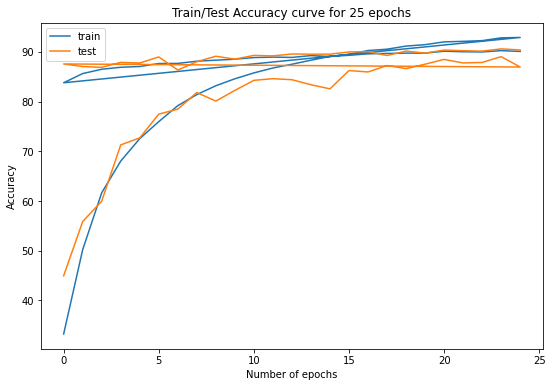

In [32]:
figureName = 'WithCutout' # change figure name

plt.figure(figsize=(9, 6))
plt.plot(results['epoch'].values, train_accuracy, label='train')
plt.plot(results['epoch'].values, test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {end_apochs} epochs')
plt.savefig(f'/content/results/{figureName}.png')
plt.legend()
plt.show()

#Adversial Attack

In [33]:
import tqdm
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 15.2 MB/s 


In [34]:
from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim

from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod

In [35]:
def softmax_activation(inputs): 
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs)) 
    
    # Normalize 
    probabilities = exp_values / np.sum(exp_values)
    return probabilities 

In [36]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True) 

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
model = net
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [40]:
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type='gpu'
)

In [41]:
from tqdm import tqdm
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
validset = torchvision.datasets.CIFAR10(root='../input/cifar10-python/', train=False,
                                       download=True, transform=transform)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=16,
                                         shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../input/cifar10-python/cifar-10-python.tar.gz to ../input/cifar10-python/


In [42]:
eps = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.20]
for e in eps:
  fgsm_attack = FastGradientMethod(estimator = classifier, eps = e)
  preds = []
  ans = []
  for batch in tqdm(valid_loader):
    imgs = batch[0]
    #     plt.imshow(imgs[0].permute(1,2,0))
    x_adv = fgsm_attack.generate(x=imgs.numpy())
    #     plt.imshow(x_adv[0].transpose(1,2,0))
    imgs_adv = torch.from_numpy(x_adv).to(device)
    with torch.no_grad():
      logits = model(imgs_adv)
      #         print(nn.Softmax(dim=1)(logits))
      #         break
      logits = logits.argmax(dim=-1).cpu().tolist()
      preds += logits
      ans += batch[1]
  cnt = 0
  for pred, an in zip(preds, ans):
      if pred == an:
          cnt += 1
  acc = cnt / len(preds)
  print(f'ACC for eps = {e} is: {acc}')

100%|██████████| 625/625 [00:27<00:00, 22.38it/s]


ACC for eps = 0.001 is: 0.9018


100%|██████████| 625/625 [00:24<00:00, 25.24it/s]


ACC for eps = 0.005 is: 0.8631


100%|██████████| 625/625 [00:25<00:00, 24.46it/s]


ACC for eps = 0.01 is: 0.7849


100%|██████████| 625/625 [00:24<00:00, 25.61it/s]


ACC for eps = 0.02 is: 0.6035


100%|██████████| 625/625 [00:24<00:00, 25.72it/s]


ACC for eps = 0.03 is: 0.4529


100%|██████████| 625/625 [00:24<00:00, 25.50it/s]


ACC for eps = 0.05 is: 0.2709


100%|██████████| 625/625 [00:24<00:00, 25.85it/s]


ACC for eps = 0.1 is: 0.1562


100%|██████████| 625/625 [00:24<00:00, 25.50it/s]


ACC for eps = 0.15 is: 0.1303


100%|██████████| 625/625 [00:24<00:00, 25.97it/s]


ACC for eps = 0.2 is: 0.1185
